# Setup

In [405]:
import kagglehub

install = False
if install:
    path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

    print("Path to dataset files:", path)

In [406]:
import pandas as pd
import os

# path to the dataset files so don't have to run above cell again
path = os.path.expanduser('~') +  "/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1"

# read data into dataframe
data_30_sec = pd.read_csv(path + "/Data/features_30_sec.csv")
data_3_sec = pd.read_csv(path + "/Data/features_3_sec.csv")

# Exploratory data analysis

In [407]:
# standard imports
import matplotlib.pyplot as plt
import seaborn as sb
import librosa
import numpy as np
plt.style.use('ggplot')

In [408]:
# missing data?
data_30_sec.head(10)
data_30_sec.describe()
data_30_sec.isnull().sum() # no missing data, data seems clean

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

## Basic plots with metadata 

Text(0.5, 1.0, 'Correlation between features')

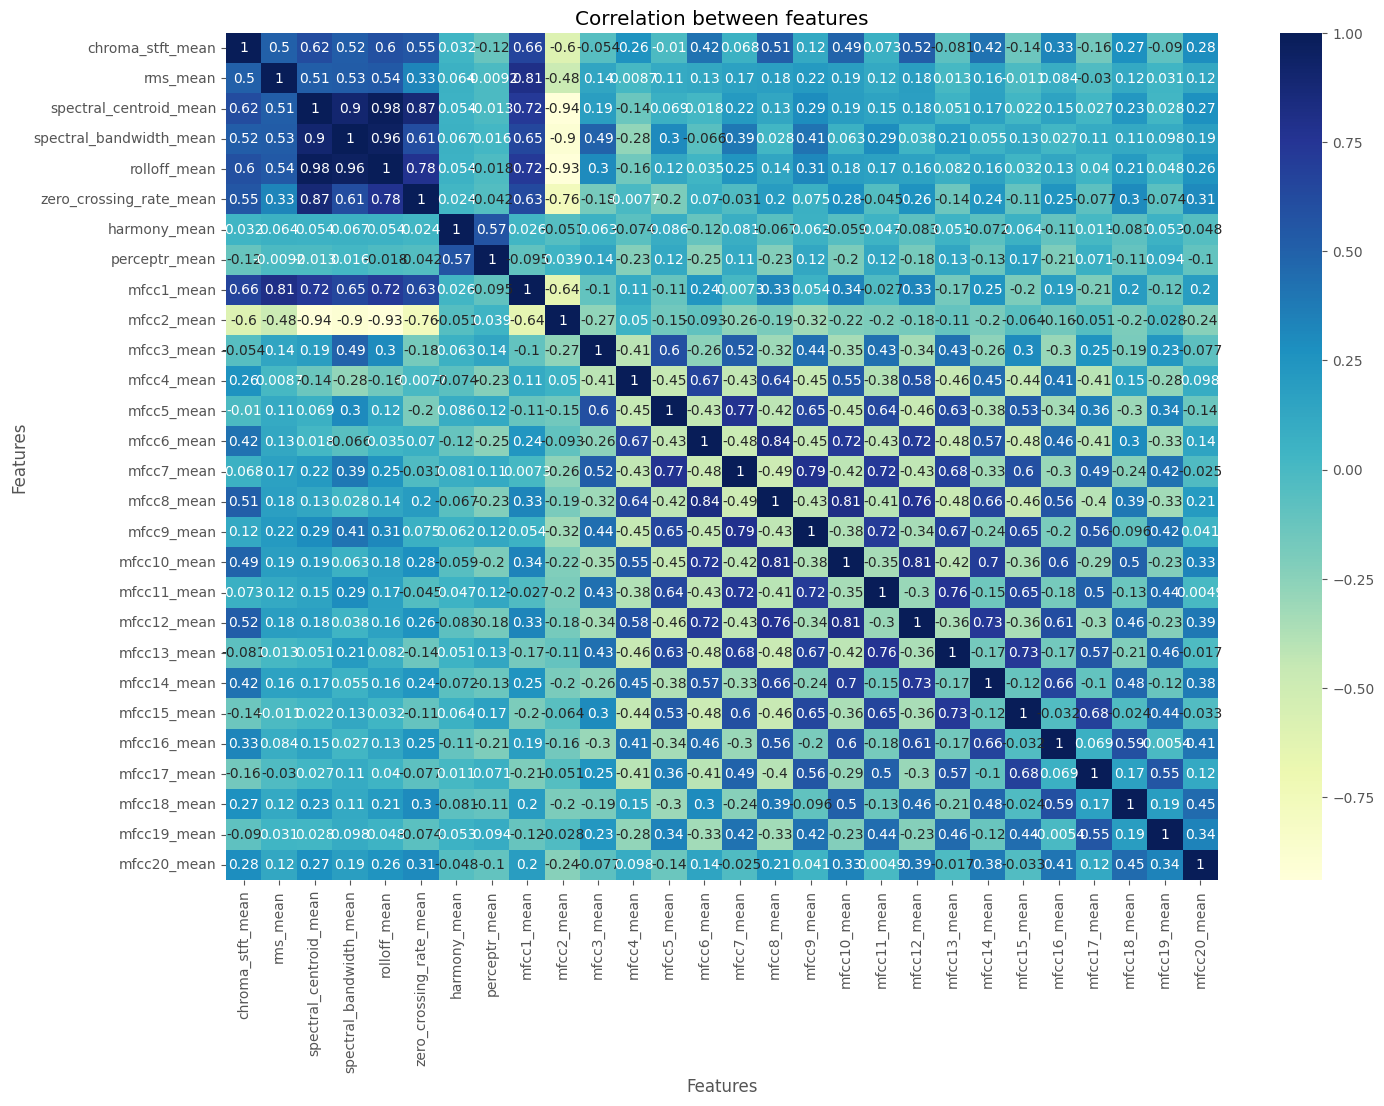

In [409]:
# Getting all the columns that have the mean data
mean_cols = [col for col in data_30_sec.columns if 'mean' in col]

fig, ax = plt.subplots(figsize=(16, 11));

dataplot = sb.heatmap(data_30_sec[mean_cols].corr(numeric_only=True), cmap="YlGnBu", annot=True)
ax.set_xlabel('Features')
ax.set_ylabel('Features')
ax.set_title('Correlation between features')
# There seems to be lots of moderately strong correlations between features, which should be useful in classification


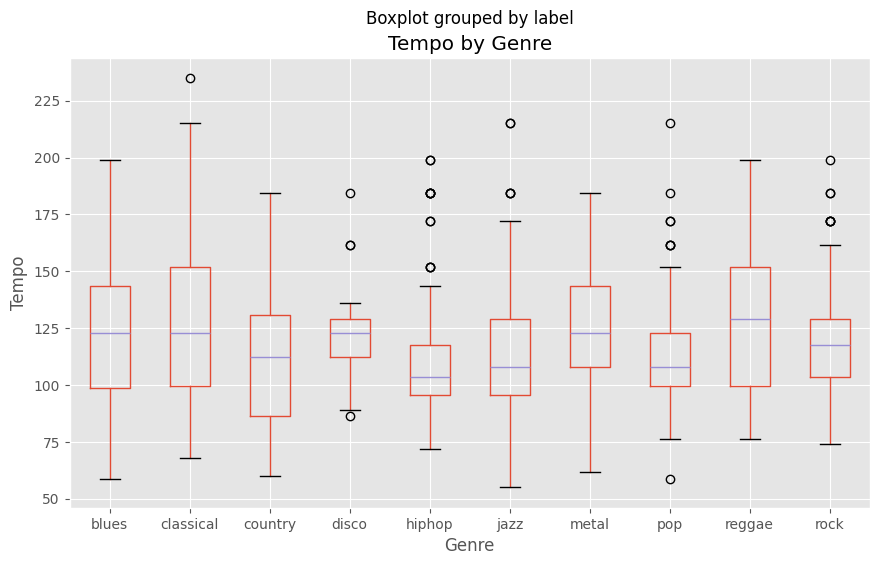

In [410]:
# plot tempo by genre
fig, ax = plt.subplots(figsize=(10, 6))
data_30_sec[['label', 'tempo']].boxplot(by = "label",ax=ax)
ax.set_title("Tempo by Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Tempo")
plt.show()

# Tempo seems somewhat predictive of genre but there is a lot of overlap between genres

## Looking at the actual music data

In [411]:
# Create an array of all the songs
all_songs = {
    file:path + "/Data/genres_original/" + genre + "/" + file
        for genre in os.listdir(path + "/Data/genres_original") 
            if genre[0] != '.'
            for file in os.listdir(path + "/Data/genres_original/" + genre) 
                if file.endswith(".wav")
}

In [412]:
import random
import os

# Choose a random music file
music_data_path = path + "/Data/genres_original/"
genre = ''
while not genre:
    genre = random.choice(os.listdir(music_data_path))
    
    # Skip if we come across some kind of hidden file
    if (genre[0] == '.'):
        genre = ''

music_data_path += f'{genre}/'
music_data_path += random.choice(os.listdir(music_data_path))

x , sr = librosa.load(music_data_path)

### Waveplot

<class 'numpy.ndarray'> <class 'int'>
(661504,) 22050
metal


Text(0.5, 1.0, 'Waveplot of the song from the metal genre')

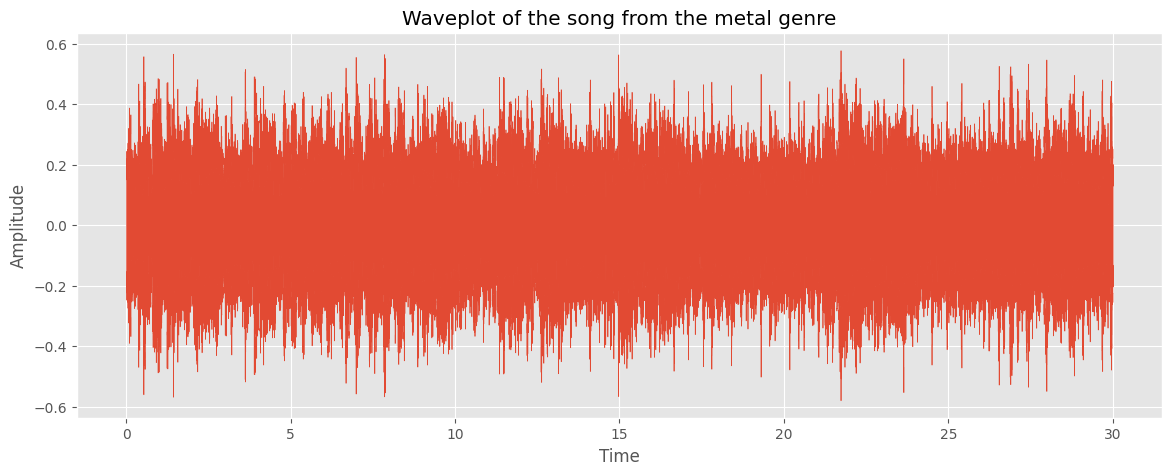

In [413]:
# the random song:
import IPython.display as ipd
import librosa.display

print(type(x), type(sr))
print(x.shape, sr)
print(genre)
ipd.Audio(x, rate=sr)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr) 
plt.ylabel("Amplitude")
plt.title(f'Waveplot of the song from the {genre} genre')

### Spectrogram
#### Shows the variation in the sound frequencies in the song

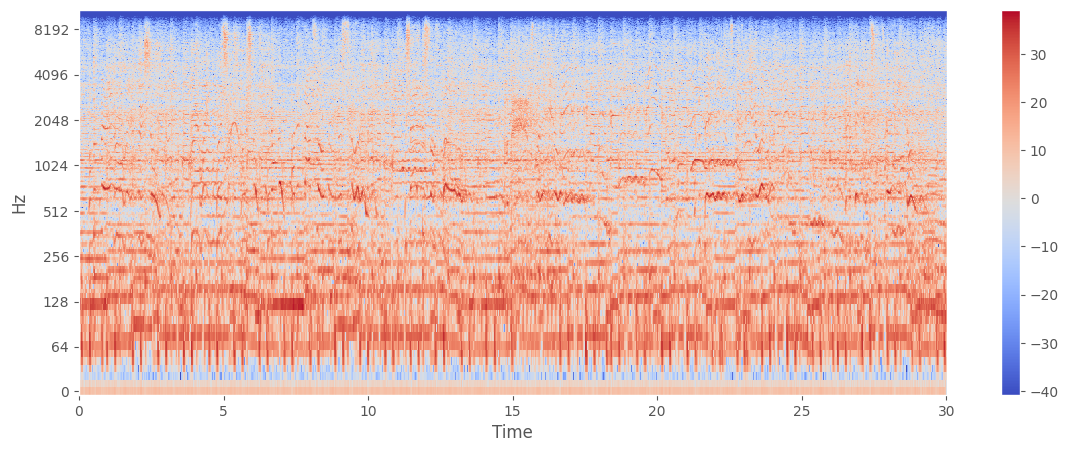

In [414]:
X = librosa.stft(x) # performs a fourier transform on the data
Xdb = librosa.amplitude_to_db(abs(X)) # converts the amplitude to decibels


# plotting
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Feature extraction 1: Zero crossing rate
#### The rate at which the signal changes from positive to negative, percussive music like metal and rock tend to have a higher zero crossing rate

3


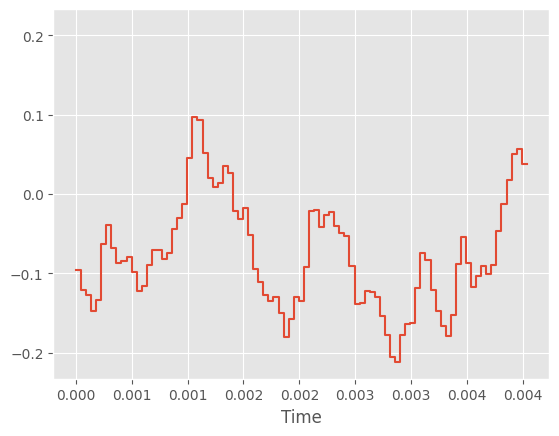

In [415]:
# Using a smaller window size so we can see what's happening
start = 10
end =  100
librosa.display.waveshow(x[start: end], sr=sr)

zero_crossings = librosa.zero_crossings(x[start:end], pad=False)
print(sum(zero_crossings)) # the signal crosses with the x-axis this many times

In [416]:
# Extract all the zero crossing rates from all songs
%pip install soundfile
import librosa
import soundfile as sf

zero_crossing_rates = {}

# process is too long to complete
if False:
    for name, path in all_songs.items():
        tempdata, tempsr = librosa.load(path)
        zero_crossings = librosa.zero_crossings(tempdata, pad=False)
        zero_crossing_rates[name] = sum(zero_crossings)

    print(zero_crossing_rates)

Note: you may need to restart the kernel to use updated packages.


### Feature extraction 2 : Spectral Centroid
#### The 'Centre of Mass' of a song. Where there is the weighted mean of the frequencies of a song

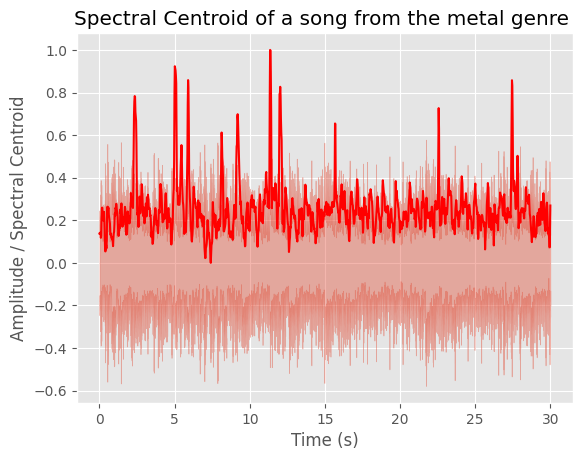

In [417]:
# This code is taken from the second article in 'README.md'
import sklearn

spectral_centroids = librosa.feature.spectral_centroid(y = x, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.title("Spectral Centroid of a song from the " + genre + " genre ")
plt.plot(t, normalize(spectral_centroids), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Spectral Centroid')

# To listen to the song
ipd.Audio(x, rate=sr) 

### Feature extraction 3: Spectral Rolloff
#### Spectral rolloff is the frequency below which x % of the frequency lives. It is the upper bound frequency

Text(31.097222222222214, 0.5, 'Threshold')

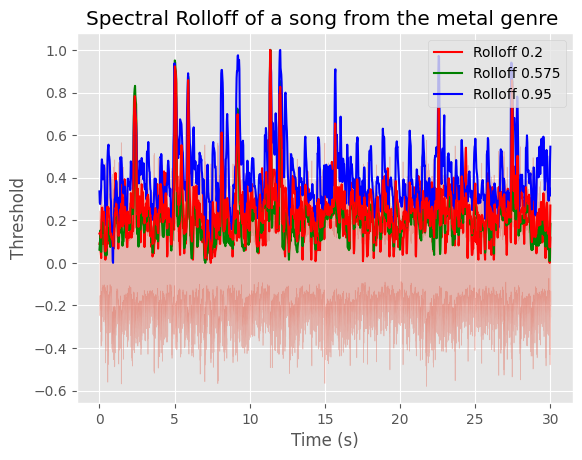

In [418]:


for perc, col in zip(np.linspace(start = 0.2, stop = 0.95, num = 3), ('r', 'g', 'b')):

    spec_rolloff = librosa.feature.spectral_rolloff(y = x, sr = sr, roll_percent = perc)[0]

    plt.plot(t, normalize(spec_rolloff), color = col)

librosa.display.waveshow(x, sr=sr, alpha=0.3)
plt.title("Spectral Rolloff of a song from the " + genre + " genre ")
plt.plot(t, normalize(spectral_centroids), color='r')
plt.xlabel('Time (s)')
plt.legend(['Rolloff 0.2', 'Rolloff 0.575', 'Rolloff 0.95'], loc='best')
plt.ylabel('Threshold')

### Feature Extraction 4: Chroma Frequencies
#### Chroma frequencies shows you the octaves used throughout the song

Text(0.5, 1.0, 'Chroma frequency graph for a metal song')

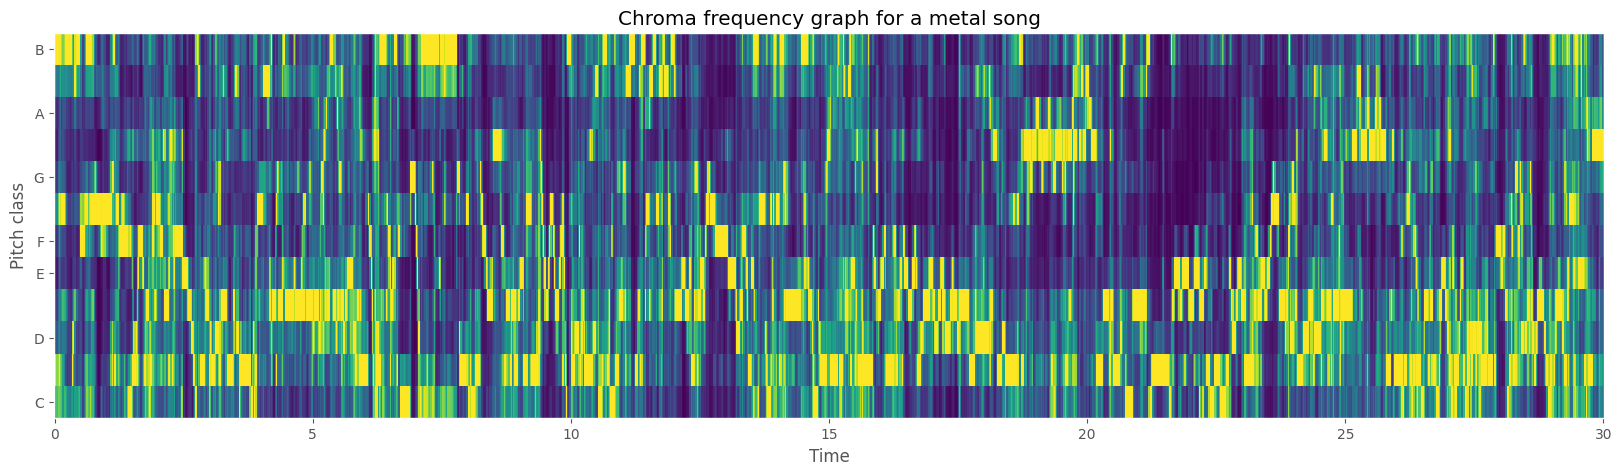

In [419]:
hop_length = 512
chroma = librosa.feature.chroma_stft(y = x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(20, 5))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='viridis')
plt.title("Chroma frequency graph for a " + genre + " song")

## Machine learning goal

### Main Goal: Accurately classify unseen songs into one of the given genres using the following 
1. PCA
1. KNN 
1. SVM
1. Random Forest
1. Neural Network

#### Sub-Goal: Discover the best method for identifying fusion songs, that is songs that are somewhat in-between two genres by using only non-fusion training data


### PCA
There are many different features for each track in the dataset. Applying dimensionality reduction can help simplify the feature space while retaining essential information and removing noise.

I need to do the following:
1. Copy the original data
1. Standardize the data
1. Figure out which components are important and use them

In [420]:
pca_data = data_30_sec.copy().drop(["filename", "length", "label"], axis = 1) # we'll be scaling the data so it's important to use a deep-copy

len(data_30_sec.columns) # 60 columns is a lot! Hopefully we can use PCA to help with that

60

In [421]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_data

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [425]:
# Scaling is an important part of PCA, otherwise the variance used to determine which features are 'important' is exaggerated by scale

# Create an object of the Std scalar class
scaler = StandardScaler()

scaler.fit(pca_data)
scaled_data = scaler.transform(pca_data)

# pca
principal = PCA(n_components=2)
principal.fit(scaled_data)
x = principal.transform(scaled_data)

print(x.shape)
print(principal.components_)

(1000, 2)
[[-0.0972025   0.17857273 -0.01165984  0.11809886 -0.01735634  0.15892139
   0.02758724  0.15696394 -0.00996695  0.16417255 -0.06949004  0.11393996
   0.02200669  0.02401139  0.06145727  0.04539055 -0.02572285 -0.09710523
   0.15169668 -0.00679755  0.18047644  0.1399991   0.15384058 -0.15436081
   0.1624272   0.15891882  0.14910186 -0.15515837  0.16668638  0.1540799
   0.1416302  -0.16081495  0.17472782  0.14425061  0.17259683 -0.14374318
   0.17139915  0.13185287  0.16403287 -0.15547637  0.16224424  0.1591668
   0.16405884 -0.1165564   0.1552974   0.15652153  0.14962326 -0.11024456
   0.14895931  0.12799744  0.14883461 -0.06187301  0.1416775   0.11081108
   0.14083716 -0.05103557  0.13916931]
 [ 0.24462161 -0.04776484  0.23104773  0.18075926  0.27406517  0.20973408
   0.27856424  0.08390818  0.27941211  0.13676509  0.20037609  0.21291139
   0.02753564  0.17282218  0.00340868  0.22786558 -0.02059292  0.2467733
  -0.01983312 -0.26476654  0.04447303  0.10386178  0.02423994 -0.0

array([-2.78356454, -1.02936476])

Text(0.5, 1.0, '2 Dimensional PCA with labelled genre')

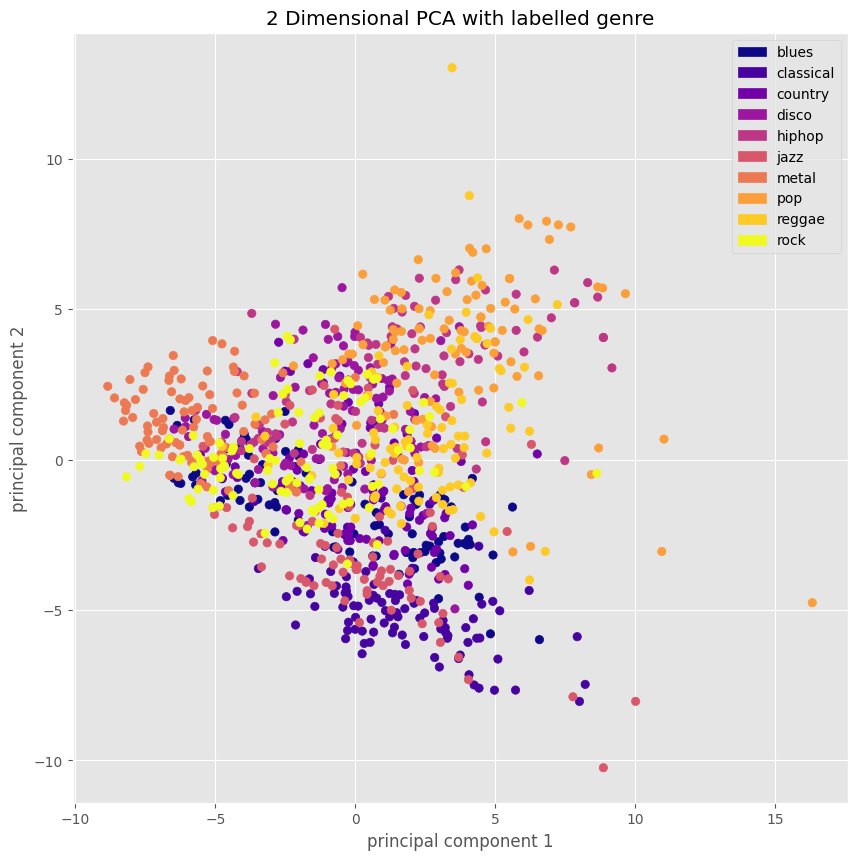

In [ ]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches

# Encode the genre labels as integers for legend purposes
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data_30_sec['label'])

plt.figure(figsize=(10,10))
scatter = plt.scatter(x[:,0], x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')

# Create a custom legend
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=label) for i, label in enumerate(data_30_sec['label'].unique())]
plt.legend(handles=handles, loc="best")

plt.title("2 Dimensional PCA with labelled genre")

# There seems to be some type of clustering. But not very dense clusters